## Overview

This is a simple VAE model that uses a convolutional encoder and decoder to learn a latent representation of the input image. 

It's a standard VAE with no tricks so it doesn't work well, but good for learning the basics.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from datetime import datetime
import os
import matplotlib.pyplot as plt

## Code for downloading CIFAR-10

In [2]:
def download_cifar10(data_path='./data'):
    """
    Download CIFAR-10 dataset and return trainset, testset, and classes

    Apply basic transformations to the data to normalize it between [-1, 1]
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_path,
        train=True,
        download=True,
        transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_path,
        train=False,
        download=True,
        transform=transform
    )

    print(f"Training set size: {len(trainset)}")
    print(f"Test set size: {len(testset)}")
    
    # CIFAR-10 classes
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')
    
    return trainset, testset, classes

def get_dataloader(trainset, testset, batch_size=128):
    """Create DataLoader objects for training and testing"""
    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_loader = DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )
    
    return train_loader, test_loader

## Code for Model Definition

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        # Encoder, trained to estimate p(z|x) from the input image(s) p(x)
        # p(z|x) is the conditional latent distribution
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [b, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # [b, 64, 8, 8]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # [b, 128, 4, 4]
            nn.ReLU(),
            nn.Flatten()  # [b, 128 * 4 * 4]
        )
        
        # Latent space, aka the estimated p(z|x) or the conditional latent distribution
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(128 * 4 * 4, latent_dim)
        
        # Decoder, used to estimate the conditional distribution of the input image p(x|z)
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # [b, 64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [b, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),   # [b, 3, 32, 32]
            nn.Tanh()
        )
    
         
    def encode(self, x):
        x = self.encoder(x) # p(z|x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
           
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x) # p(x|z)
        return x
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from the latent distribution while allowing backpropagation

        
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


In [4]:

def vae_loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (using MSE since our images are normalized)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Total loss is the sum of both
    total_loss = recon_loss + kl_loss
    
    return total_loss, recon_loss, kl_loss

def save_image_samples(model, data, writer, epoch, device):
    """Save original and reconstructed images to tensorboard"""
    model.eval()
    with torch.no_grad():
        # Get reconstructions
        data = data.to(device)
        recon_batch, _, _ = model(data)
        
        data_cpu = data[:8].cpu()
        recon_cpu = recon_batch.cpu()[:8]
        comparison = torch.cat([
            data_cpu,  # Original images
            recon_cpu  # Reconstructed images
        ])
        
        # Add images to tensorboard
        writer.add_images('Original_Reconstructed', comparison, epoch)

def train_epoch(model, train_loader, optimizer, device, writer, epoch):
    model.train()
    
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    n_samples = len(train_loader.dataset)

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss, recon_loss, kl_loss = vae_loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    save_image_samples(model, data, writer, epoch, device)  # Using the last batch
    

    avg_loss = train_loss / n_samples
    avg_recon_loss = train_recon_loss / n_samples
    avg_kl_loss = train_kl_loss / n_samples
    
    writer.add_scalar('Loss/train/total', avg_loss, epoch)
    writer.add_scalar('Loss/train/reconstruction', avg_recon_loss, epoch)
    writer.add_scalar('Loss/train/kl_divergence', avg_kl_loss, epoch)
    return avg_loss

In [5]:

def train_vae(epochs=100, batch_size=128, learning_rate=1e-3):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {DEVICE}")
    # Get data
    trainset, testset, _ = download_cifar10()  # Using your existing function
    train_loader, test_loader = get_dataloader(trainset, testset, batch_size)
    
    # Initialize model, optimizer, and tensorboard
    model = VAE().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log_dir = f'runs/VAE_CIFAR10_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
    writer = SummaryWriter(log_dir)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, DEVICE, writer, epoch)
        
        # Save a checkpoint every 10 epochs
        if epoch % 10 == 0:
            if not os.path.exists(f'{log_dir}/models'):
                os.makedirs(f'{log_dir}/models')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, f'{log_dir}/models/vae_checkpoint_epoch_{epoch}.pt')
    
    writer.close()

In [6]:
# train_vae(epochs=200, batch_size=128, learning_rate=1e-3)


In [7]:

def generate_and_display_samples(log_dir, epoch=100, num_samples=64, latent_dim=128, device='cuda'):
    """Generate and display random samples from the VAE decoder"""
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VAE(latent_dim=128).to(DEVICE)

    # Load the checkpoint
    checkpoint = torch.load(f'{log_dir}/models/vae_checkpoint_epoch_{str(epoch).zfill(3)}.pt', weights_only=True)  # adjust epoch number as needed
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set to evaluation mode
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)
        
        # Generate images
        samples = model.decode(z)
        
        # Denormalize images from [-1, 1] to [0, 1]
        samples = (samples + 1) / 2
        
        # Move to CPU and convert to numpy
        samples = samples.cpu()
        
        # Create a grid of images
        fig, axes = plt.subplots(8, 8, figsize=(15, 15))
        for idx, ax in enumerate(axes.flat):
            # Convert from [C,H,W] to [H,W,C] format
            img = samples[idx].permute(1, 2, 0)
            
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return samples

C:\Users\boxing-gloves-0520\AppData\Local\Temp\ipykernel_14104\2104009230.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{log_dir}/models/vae_

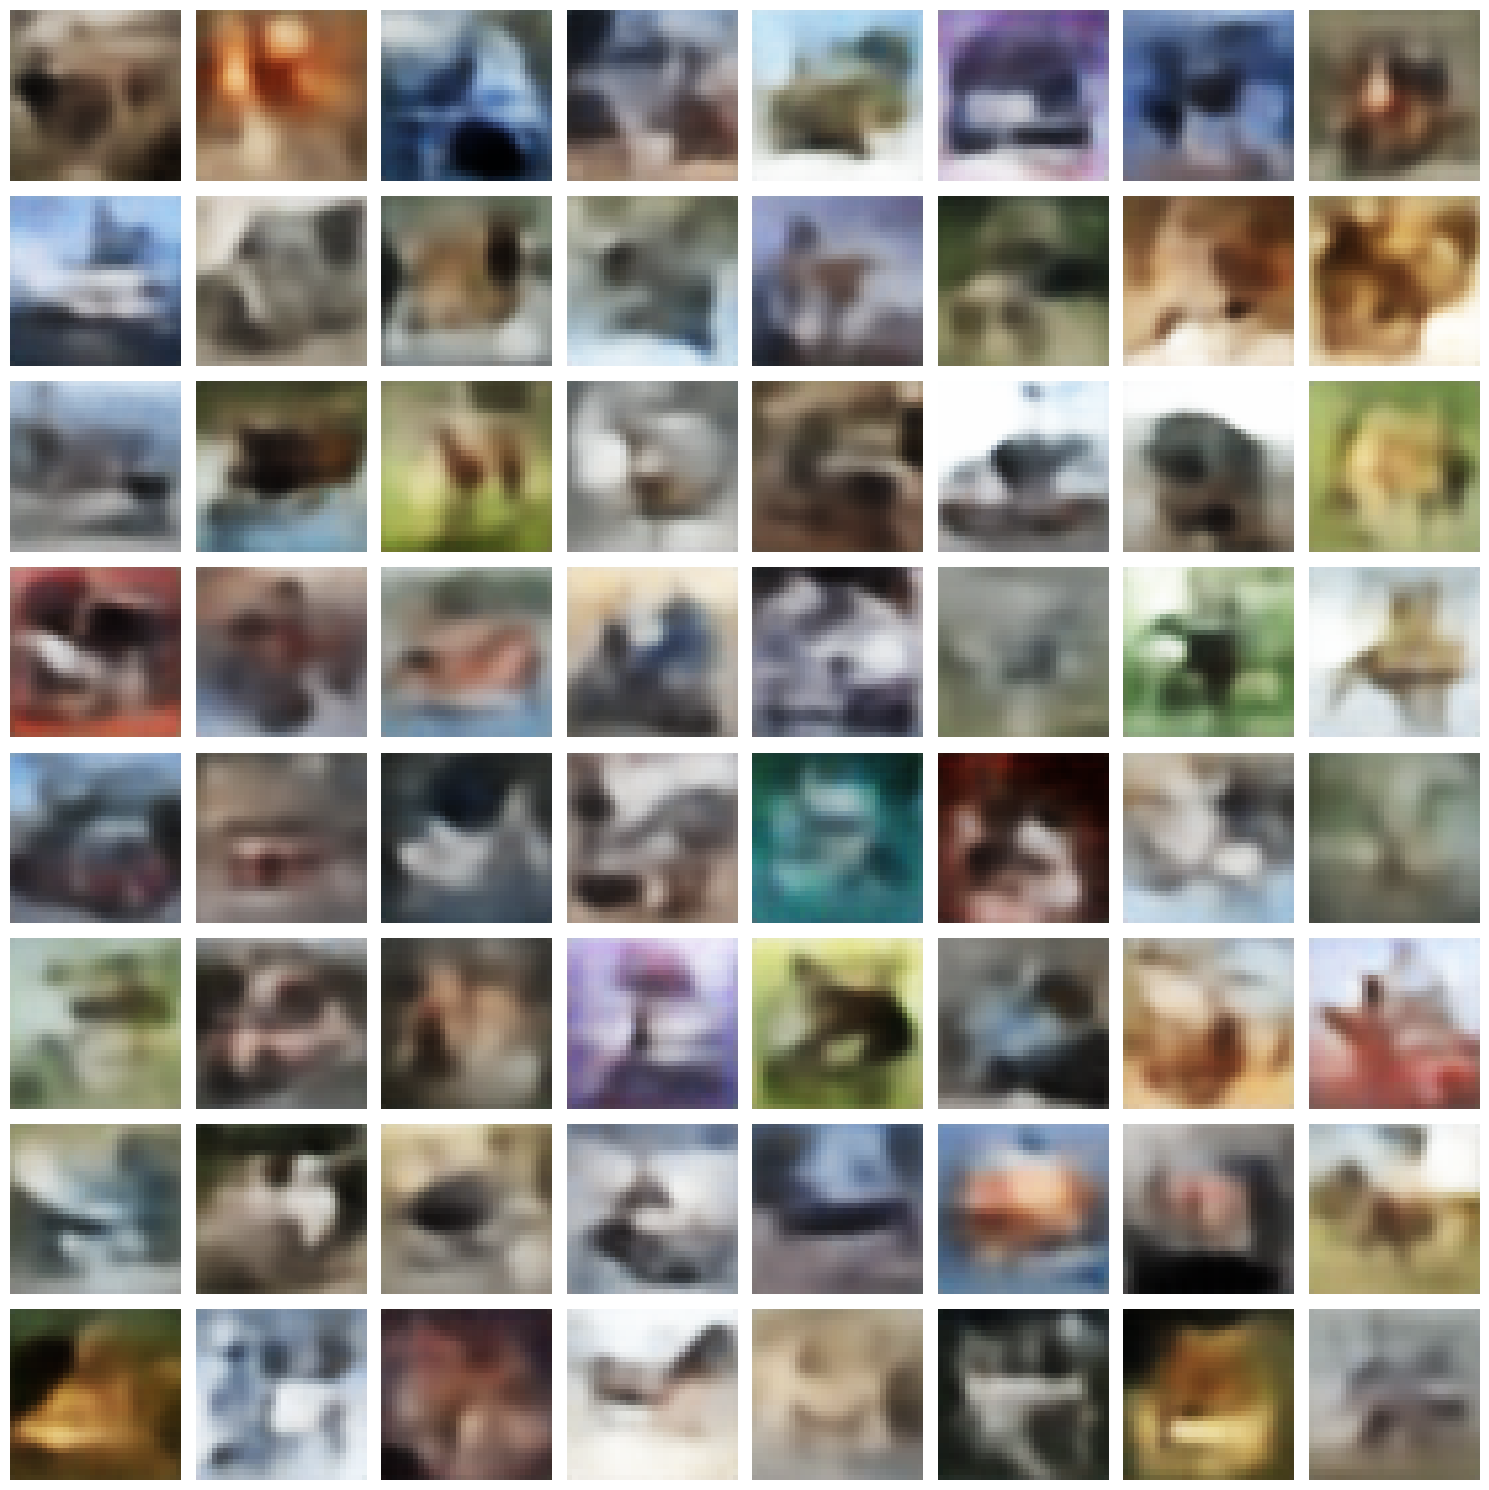

In [8]:
# Initialize a new model instance
log_dir = './runs/VAE_CIFAR10_20241226-181029'
samples = generate_and_display_samples(log_dir, 200)

# Optionally save to disk
torchvision.utils.save_image(samples, 'vae_samples.png', nrow=8, normalize=True)